In [43]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import collections
import random
from typing import List, Tuple
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

In [24]:
def import_edge_connections(file_name: str) -> dict:
    """
    Given the name of a file containing information about edges in a graph,
    return a dictionary where the keys are the edge numbers and the values are lists
    containing the numbers of the nodes that the edge connects.
    """
    edge_connections = {}
    with open(file_name, "r") as file:
        for line in file:
            parts = line.strip().split(" ")
            edge_num = int(parts[0])
            connections = [int(c) for c in parts[1:]]
            edge_connections[edge_num] = connections
    return edge_connections

def import_restrictions(file_name: str) -> List[Tuple[int, int, int]]:
    """
    Given the name of a file containing information about restrictions in a graph,
    return a list of tuples where each tuple contains three integers:
    the numbers of the two edges that are restricted and the distance between them.
    """
    restrictions = []
    with open(file_name, "r") as file:
        for line in file:
            parts = line.strip().split(" ")
            edge1 = int(parts[0])
            edge2 = int(parts[1])
            prohibited = int(parts[2])
            restrictions.append((edge1, edge2, prohibited))
    return restrictions

In [25]:
edge_connections = import_edge_connections('./Links Короб.txt')
restrictions = import_restrictions('./Constraints Короб.txt')


In [26]:
def visualize_graph(edge_connections):
    """
    Given a dictionary containing information about the connections between edges in a graph,
    visualize the graph using networkx and matplotlib.
    """
    G = nx.Graph()
    for edge, connections in edge_connections.items():
        for connection in connections:
            G.add_edge(edge, connection)
    pos = nx.spring_layout(G, seed=42) # Layout nodes using the Fruchterman-Reingold force-directed algorithm
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)
    plt.show()


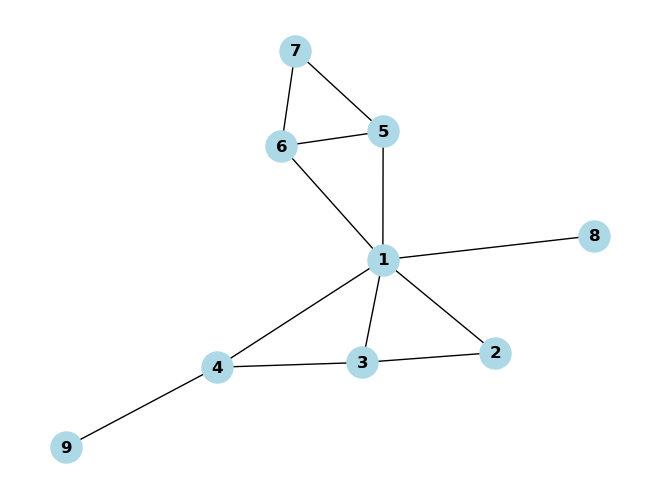

In [27]:
visualize_graph(edge_connections)

In [28]:
def check_condition(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 not in path:
        return False
    elif node3 in path:
        return "Done"
    else:
      return True


In [29]:
def dfs(node: int, visited: List[bool], path: List[int], all_paths: List[List[int]], restrictions_local:  List[List[int]], depth: int):
        visited[node-1] = True
        path.append(node)

        sum_locked = 0
        len_start = len(restrictions_local)
        for restrict in restrictions_local:
          check_result =  check_condition(restrict[0], restrict[1], restrict[2], path)
          if not check_result:
            #print(f" decline {restrict[0], restrict[1], restrict[2], path}")
            sum_locked += 1
          elif check_result == "Done":
           # print(f"Done {restrict[0], restrict[1], restrict[2]}")
            #print(len(restrictions_local))
            restrictions_local.remove(restrict)

        if sum_locked:
            all_paths.append(path[:])
            #print(f"solved: {path}")
            path.pop()
            visited[node-1] = False
            return "Error"


        if path[-4:-2] == path[-2:]:
          #print(f'declined path {path}')
          path.pop()
          visited[node-1] = False
          return None

        if all(visited):
            #print(visited)
            all_paths.append(path[:])
            #print(f"solved: {path}")
            path.pop()
            visited[node-1] = False
            return "Done"

        elif depth >= 10 :
            path.pop()
            #print(depth)
            visited[node-1] = False
            return "Max"

        else:
          for neighbor in edge_connections[node]:
                result = dfs(neighbor, visited.copy(), path, all_paths, restrictions_local.copy(),depth+1)

        visited[node-1] = False
        path.pop()


In [30]:
def find_all_paths(edge_connections: dict, restrictions: List[List[int]]) -> List[List[int]]:
    """
    Given a dictionary of edge connections, return a list of all available paths for traversing
    the graph with repetitions, starting and ending at any node, and visiting all nodes,
    """
    all_nodes = list(edge_connections.keys())
    all_paths = []
    for start_node in tqdm(all_nodes):
        #print(f"start {start_node}")
        visited = [False] * len(all_nodes)
        path = []
        dfs(start_node, visited, path, all_paths, restrictions.copy(), 1)

    return all_paths


In [31]:
def clean_list(all_path, final_name):
  finall_results = {}
  final = []
  for path in all_path:
    name = ','.join(str(x) for x in np.unique(path))
    name = str(np.unique(path))
    # print(len(path))
    if name in finall_results.keys():
      if len(path) < len(finall_results[name]):
        finall_results[name] = path
    elif name == final_name:
      final.append(path)
    else:
      finall_results[name] = path
  print(final)
  if final:
    finall_results[final_name] = final
  return finall_results



In [32]:
all_paths = find_all_paths(edge_connections, restrictions)
final_name = ','.join(str(x) for x in edge_connections)
clean_paths = clean_list(all_paths,final_name)

100%|██████████| 9/9 [00:00<00:00, 155.59it/s]

[]


In [33]:
import pandas as pd
df = pd.DataFrame(np.zeros((1,4)), 
                      columns= ["start","end","body","connections"] )
df = df.astype({"start" :int,"end" : int, "body" : object,"connections" : object})

for i,r1 in enumerate(clean_paths.values()):
    df.at[i,"start"] = r1[0]
    df.at[i,"end"] = r1[-1]
    df.at[i,"body"] = r1
    df.at[i,"connections"] = []
    df.at[i,"unique"] = len(pd.unique(r1))

for node in edge_connections:
    started = df[df["start"] == node].index
    _ = df[df["end"].isin(edge_connections[node])]["connections"].apply(lambda x: x.extend(started))

df = df.astype({"start" :int,"end" : int, "body" : object,"connections" : object, "unique" :int})


In [34]:
def greedy_cover(stations: dict):
    """
    Используйте жадный алгоритм для решения установленной проблемы покрытия: выберите наименее вещательную станцию, чтобы все области могли принимать сигнал
    :param stations:
    :return:
    """

    # Создайте набор для хранения областей, которые должны быть покрыты, но еще не покрыты
    not_cover = set()
    for v in stations.values():
        for s in v:
            not_cover.add(s)
    unique_num = len(not_cover)
    selects = []  # Сохранить нашу выбранную станцию
    while True:
        # Сначала выберите станцию, которая покрывает наиболее непокрытую территорию
        max_key = ''
        max_num = 0
        for k in stations.keys():
            intersection = not_cover.intersection(stations[k])
            if len(intersection) > max_num:
                max_key = k
                max_num = len(intersection)
        selects.append(max_key)
        # Затем удалите зону покрытия выбранной радиостанции из not_cover
        for e in stations[max_key]:
            if e in not_cover:
                not_cover.remove(e)
        # Если not_cover не пусто, то есть покрыты все области, можно завершить алгоритм
        if len(not_cover) == 0:
            break

    if len(not_cover) !=0:
        return False
    return selects,unique_num



In [35]:
def check_condition_order(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 in path:
      idx1 = np.where(path == node1)[0][0]
      idx2 = np.where(path == node2)[0][0]
      idx3 = np.where(path == node3)[0][0]
      if idx3 > idx1 and idx3 > idx2:
        return False
      else:
        return True
    else:
      return True


In [19]:
def check_condition_order_with__full_return(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 in path:
      idx1 = np.where(path == node1)[0][0]
      idx2 = np.where(path == node2)[0][0]
      idx3 = np.where(path == node3)[0][0]
      if idx3 > idx1 and idx3 > idx2:
        return [node1,node2,node3]
      else:
        return 0
    else:
      return 0
    
def check_condition_order_with_return(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 in path:
      idx1 = np.where(path == node1)[0][0]
      idx2 = np.where(path == node2)[0][0]
      idx3 = np.where(path == node3)[0][0]
      if idx3 > idx1 and idx3 > idx2:
        return node3
      else:
        return 0
    else:
      return 0
    
def check_if_possible(path, verbose = False):
    _,counts = np.unique(path,return_counts=True) 
    a = [check_condition_order_with_return(rest[0],rest[1],rest[2],np.array(path)) for rest in restrictions]
    if verbose:
        print(a)
        print(counts)
    for i in a:
        if i != None and i!=0:
            if counts[i-1] == 1:
                if verbose:
                    print(f"canceled due to {restrictions[i]}")
                return False
    return True

def can_be_connected(operations,order, bodypart, verbose = False):
    oper = operations.copy()
    o = 0
    operation_parts = [[] for n in oper]
    for n in order:
        
        if n in oper[0]:
            if verbose:
                print(o)
                print(f"{n} {o}")
            operation_parts[o].append(n)
            pass
        elif n in oper[1]:
            if verbose:
                print("++")
                print(f"{oper} and {n}")
            oper = oper[1:]
            o+=1
            if verbose:
                print(f"{n} {o}")
            operation_parts[o].append(n)
        else:
            oper = oper[1:]
    if verbose:
        print(operation_parts)
    prev_operation = None
    for operation, next_operation in zip(operation_parts,operation_parts[1:]):
        if operation:
            connected = False
            if verbose:
                print(operation)
            if operation[0] in next_operation:
                connected = True
            for one, next in zip(operation,operation[1:]):
                if not next in edge_connections[one] and one!=next:
                    if verbose:
                        print(f"{next} cannot be connected with {one}")
                    return False # false if not connected inside one operation
                if not connected and (one in next_operation):
                    connected = True


            if not connected:
                if verbose:
                    print(next_operation)
                if next_operation and not next_operation[0] in edge_connections[operation[-1]] and not bodypart in operation:
                    if prev_operation and  not operation[0] in edge_connections[prev_operation[-1]]:
                        if verbose:
                            print(f"{operation} cant be connected to previous pipes")
                        return False # False if not connected between operations
        prev_operation = operation

    return True

def final_rest_check_and_connections(operations,new1, bodypart, verbose = False):
  
  if not can_be_connected(operations, np.delete(new1, new1==0), bodypart, verbose):
        if verbose:
            print(f"cant be connected {operations} and {np.delete(new1, new1==0)}") 
        return False
  
  if not all((check_condition_order(rest[0],rest[1],rest[2],new1) for rest in restrictions)):
        if verbose:
            print(f"{operations} restrictions hit hard {list(check_condition_order_with__full_return(rest[0],rest[1],rest[2],new1) for rest in restrictions)}")
        return False

  return  True 

In [20]:
def is_connected_inside_operation(operation, verbose = False):
    for one, next in zip(operation,operation[1:]):
                if not next in edge_connections[one] and one!=next:
                    if verbose:
                        print(f"{next} cannot be connected with {one}")
                    return False # false if not connected inside one operation
    return True


def can_be_connected(operations,order, body_part, warning_fail = False, verbose = False):
    oper = operations.copy()
    o = 0
    operation_parts = [[] for n in oper]
    for n in order:
        while True:
            if n in oper[0]:
                if verbose:
                    print(o)
                    print(f"{n} {o}")
                operation_parts[o].append(n)
                break
            elif n in oper[1]:
                if verbose:
                    print("++")
                    print(f"{oper} and {n}")
                oper = oper[1:]
                o+=1
                if verbose:
                    print(f"{n} {o}")
                operation_parts[o].append(n)
                break
            else:
                oper = oper[1:]

    operation_parts = [sublist for sublist in operation_parts if sublist]

    if verbose:
        print(operation_parts)

    prev_operation = None
    body_connected = False
    corrected_oper_list = []
    ongoing_operation = []
    for num, operation in enumerate(operation_parts):
        if not is_connected_inside_operation(operation, verbose):
            if verbose:
                print(f"Conflict inside operation {operation}")
            if warning_fail:
                return False

        if body_part in operation:
            prev_operation = operation

            if ongoing_operation != [] and body_connected:
                corrected_oper_list.append(ongoing_operation)
                ongoing_operation = []
            body_connected = True
            ongoing_operation.extend(operation)
            if verbose:
                print(f"{operation} is body connected")
            continue
        else:
            if (
                prev_operation != None and 
                prev_operation[-1] in edge_connections[operation[0]] and
                body_part in prev_operation             
            ): # Если это не первая операция и она соединяется последовательно с прошлой, то продолжаем цикл без изменения body_connected статуса, тк это одна последовательность
                if verbose:
                    print(f"{operation} connected with {prev_operation}")
                prev_operation = operation
                ongoing_operation.extend(operation)
                continue
            elif prev_operation == None:
                prev_operation = operation
                
            
            if ( num < len(operation_parts) - 1  and
                operation[-1] in edge_connections[operation_parts[num+1][0]] and
                (body_connected or body_part in operation_parts[num+1])
            ): # Следующая операция является продолжением текущей и текущая или следующая операция соединениа с БП, то все файн. Не меняем БП
                if verbose:
                    print(f"{operation} connected with {operation_parts[num+1]}")
                ongoing_operation.extend(operation)
                prev_operation = operation
                continue
            elif (
                num < len(operation_parts) - 1 and 
                not body_connected and
                not body_part in operation_parts[num+1]
            ):
                body_connected = False
                if verbose:
                    print(f"{operation} and {operation_parts[num+1]} not connected to body, Waiting")
                ongoing_operation.extend(operation)
                prev_operation = operation
                continue
            if verbose:
                print(f"{operation} cant be connected to chain")
                if not body_connected: print("no body connect")
            return False
    corrected_oper_list.append(ongoing_operation)
    return corrected_oper_list


def final_rest_check_and_connections(operations,new1, bodypart, verbose = False):
  oper =  can_be_connected(operations, np.delete(new1, new1==0), bodypart, verbose)
  if not oper:
        if verbose:
            print(f"cant be connected {operations} and {np.delete(new1, new1==0)}") 
        return False
  
  if not all((check_condition_order(rest[0],rest[1],rest[2],new1) for rest in restrictions)):
        if verbose:
            print(f"{operations} restrictions hit hard {list(check_condition_order_with__full_return(rest[0],rest[1],rest[2],new1) for rest in restrictions)}")
        return False

  return  oper 

In [ ]:
[] == []

True

In [ ]:
for_output,i

(array([list([6, 7, 1, 7, 8, 7, 1, 5]), list([4, 2, 1, 10]),
        list([9, 10, 1, 3]), list([6, 7, 1, 7, 8, 7, 1, 10])], dtype=object),
 array([ 8.,  2.,  4.,  9., 10.,  1.,  3.,  6.,  7.,  1.,  5.]))

In [ ]:
can_be_connected([[4, 2, 1, 3], [9, 10, 1, 7], [6, 7, 1, 8, 3], [6, 7, 1, 8, 5]],[ 4,  2, 1, 9, 10,  7,  6,  1,  8,  3,  5,],1, verbose=True)

0
4 0
0
2 0
0
1 0
++
[[4, 2, 1, 3], [9, 10, 1, 7], [6, 7, 1, 8, 3], [6, 7, 1, 8, 5]] and 9
9 1
1
10 1
1
7 1
++
[[9, 10, 1, 7], [6, 7, 1, 8, 3], [6, 7, 1, 8, 5]] and 6
6 2
2
1 2
2
8 2
2
3 2
++
[[6, 7, 1, 8, 3], [6, 7, 1, 8, 5]] and 5
5 3
[[4, 2, 1], [9, 10, 7], [6, 1, 8, 3], [5]]
[4, 2, 1] is body connected
7 cannot be connected with 10
Conflict inside operation [9, 10, 7]
[9, 10, 7] connected with [6, 1, 8, 3]
1 cannot be connected with 6
Conflict inside operation [6, 1, 8, 3]
[6, 1, 8, 3] is body connected
[5] connected with [6, 1, 8, 3]


[[4, 2, 1, 9, 10, 7], [6, 1, 8, 3, 5]]

In [ ]:
[1,2,3] + [3,4,5]

[1, 2, 3, 3, 4, 5]

Условия коннекта

In [21]:
def reverse_operations(operations,order, verbose = False):
    oper = operations.copy()
    o = 0
    operation_parts = [[] for n in oper]
    for n in order:
        
        if n in oper[0]:
            if verbose:
                print(o)
                print(f"{n} {o}")
            operation_parts[o].append(n)
            pass
        elif n in oper[1]:
            if verbose:
                print("++")
                print(f"{oper} and {n}")
            oper = oper[1:]
            o+=1
            if verbose:
                print(f"{n} {o}")
            operation_parts[o].append(n)
        else:
            oper = oper[1:]
    return operation_parts

# 6 7 1 8 2 9 10 3 4  5

In [67]:

results = greedy_cover(df.sample(frac=0.1).to_dict("dict")["body"])
uniques = len(edge_connections)
body_part = 1


solutions = pd.DataFrame(np.zeros((1,4)), 
                      columns= ["id","operations","order","full"] )
solutions = solutions.astype({ "id":int,"operations" : object,"order" : object,"full":object})
df_rows_counter = 0
res_prom = []
id_checked = Counter()
skipped_count = 0
check_count = 0
append_count = 0
is_run = True
frac_dynamic = 0.5
while (len(solutions) < 2 and is_run):
    skipped_count_local = 0
    check_count_local = 0
    bar = tqdm(range(10000))
    for iter_i in bar:
        if not is_run:
             break
        result,unique_num = greedy_cover(df.sample(frac=frac_dynamic).to_dict("dict")["body"])
        if not result or unique_num!=len(edge_connections):
            continue
        for var in it.permutations(result):
            if not id_checked[var]:
                id_checked[var] = True
                    #print(f"finded {var} in {res}")
                check_count+=1
                check_count_local+=1
            else:
                    #print(f"skipped {var}")
                skipped_count+=1
                skipped_count_local+=1
                continue
            result_path = np.concatenate(list(df.iloc[list(var)]["body"]))
            for_output = df.iloc[list(var)]["body"].values

            # if all(i in result for i in [36,22,4]):
            #             print(result_path)
            #             print(for_output)
            #             is_run = False
            #             break
            if result[0] == 36 and result[1] == 22 and result[2] == 4:
                print(result_path)
                print(for_output)
                is_run = False
                break

            if check_if_possible(result_path):
                coun = append_count
                # problems = []
                # for rest in restrictions:
                #     if check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path):
                #         problems.extend(check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path))

                # er = np.unique(problems)

                # problems = []
                # for i in er:
                #     problems.append(list(np.where(result_path==i)[0]))


                # import itertools

                # new = result_path.copy()
                # for i in er:
                #     new[np.where(result_path == i)] = 0

                # for arr in itertools.product(*problems):
                #     new1 = new.copy()
                #     for pos,value in zip(arr,er):
                #         new1[pos] = value
                        
                #     if final_rest_check_and_connections(for_output,new1, 1):
                #         print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in pd.Series(for_output)]} подходит путь {np.delete(new1, new1==0)} с операциями {reverse_operations(for_output,np.delete(new1, new1==0))}")
                #         solutions.loc[len(solutions.index)+1] = [coun,[list(pd.unique(one)) for one in pd.Series(for_output)], np.delete(new1, new1==0), reverse_operations(for_output,np.delete(new1, new1==0))]
                #         append_count+=1
                #         break

                for i in unique_combinations_from_full_path(result_path,[1,2]):
                    oper = final_rest_check_and_connections(for_output,i, 1)
                    if oper:
                                        print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in pd.Series(for_output)]} подходит путь {i} с операциями {oper} {var}")
                                        solutions.loc[len(solutions.index)+1] = [coun,[list(pd.unique(one)) for one in pd.Series(for_output)], i, oper]
                                        append_count+=1
                                        res_prom.append(reverse_operations(for_output,i))
                                        break
        bar.set_description(f"Checked chains {check_count}, Skipped {skipped_count}, append {append_count}")
    if check_count_local and skipped_count_local/check_count_local > 0.05:
        frac_dynamic = frac_dynamic/2
        print(f"frac_dynamic = {frac_dynamic}\n")
    print(f"\n {check_count}")

Checked chains 246, Skipped 24, append 0:   0%|          | 18/10000 [07:11<50:54:47, 18.36s/it]

In [76]:
import csv
with open('out.csv', 'w', newline='') as f:
    writer = csv.writer(f,delimiter=";")
    writer.writerows(solutions["full"].iloc[1:].to_list())

In [74]:
solutions["full"].iloc[1:].to_list()

[[[8.0, 1.0, 5.0, 7.0, 9.0, 3.0], [1.0, 2.0, 4.0, 6.0]],
 [[9.0, 3.0, 1.0, 5.0, 7.0, 4.0, 8.0, 1.0, 2.0, 6.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1.0, 2.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 1.0, 4.0, 9.0, 6.0]],
 [[1.0, 5.0, 7.0], [8.0, 1.0, 3.0, 2.0, 4.0, 9.0, 6.0]],
 [[1.0, 5.0, 7.0], [3.0, 2.0, 4.0, 9.0, 1.0, 8.0, 6.0]],
 [[1.0, 3.0, 2.0, 4.0, 9.0], [5.0, 7.0, 1.0, 8.0, 6.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 2.0, 1.0, 4.0, 9.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1.0, 2.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 1.0, 4.0, 9.0, 6.0]],
 [[1.0, 5.0, 7.0], [8.0, 1.0, 3.0, 2.0, 4.0, 9.0, 6.0]],
 [[1.0, 5.0, 7.0], [3.0, 4.0, 9.0, 1.0, 8.0, 2.0, 6.0]],
 [[1.0, 3.0, 4.0, 9.0], [5.0, 7.0, 1.0, 8.0, 2.0, 6.0]],
 [[1.0, 5.0, 7.0, 6.0], [8.0, 1.0, 3.0, 2.0, 4.0, 9.0]],
 [[1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1.0, 8.0, 2.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 2.0, 1.0, 4.0, 9.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1.0, 2.0]],
 [[1.0, 3.0, 2.0, 4.0], [5.0, 7.0

In [33]:
res_prom

[[[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 2.0, 1.0], [4.0, 9.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1.0], [2.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 1.0], [4.0, 9.0, 6.0]],
 [[8.0, 1.0, 5.0, 7.0], [3.0, 2.0, 1.0, 4.0], [9.0, 6.0]],
 [[8.0, 1.0, 5.0, 7.0], [3.0, 4.0, 9.0, 1.0], [2.0, 6.0]],
 [[1.0, 9.0], [8.0, 5.0, 7.0, 1.0], [3.0, 2.0, 4.0, 6.0]],
 [[9.0, 3.0], [1.0, 2.0], [8.0, 1.0, 5.0, 7.0, 6.0, 4.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 6.0], [7.0, 1.0, 4.0], [9.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 6.0, 1.0, 4.0], [9.0], [7.0, 1.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 7.0], [6.0, 1.0, 4.0], [9.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 4.0], [9.0, 1.0], [6.0]],
 [[8.0, 1.0, 3.0, 2.0], [9.0, 4.0], [5.0, 6.0], [7.0, 1.0]],
 [[8.0, 1.0, 3.0, 2.0], [9.0, 4.0], [5.0, 7.0], [6.0, 1.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 1.0, 4.0], [9.0, 6.0]],
 [[1.0, 5.0, 7.0], [8.0, 1.0, 3.0, 2.0, 4.0], [9.0, 6.0]],
 [[1.0, 5.0, 7.0], [3.0, 2.0, 4.0, 9.0, 1.0], [8.0, 6.0]],
 [[1.0, 3.0, 2.0, 4.0, 9.0], [5.0, 7.0,

In [62]:
solutions["full"]

0                                                    0.0
2      [[8.0, 1.0, 5.0, 7.0, 9.0, 3.0], [1.0, 2.0, 4....
3      [[9.0, 3.0, 1.0, 5.0, 7.0, 4.0, 8.0, 1.0, 2.0,...
4      [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1....
5      [[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 1.0, 4.0, 9....
                             ...                        
389    [[3.0, 9.0, 1.0, 8.0, 5.0, 7.0, 4.0, 2.0], [1....
390    [[1.0, 5.0, 7.0, 6.0], [8.0, 3.0, 4.0, 9.0, 1....
391    [[1.0, 5.0, 7.0, 6.0], [8.0, 3.0, 2.0, 1.0, 4....
392    [[1.0, 3.0, 2.0, 4.0, 9.0], [5.0, 8.0, 1.0, 6....
393    [[1.0, 3.0, 2.0, 4.0, 9.0, 1.0, 5.0, 6.0, 7.0]...
Name: full, Length: 393, dtype: object

In [65]:
solutions["full"].iloc[1:].to_csv("./result.csv", sep = ";")

[0.0,
 [[8.0, 1.0, 5.0, 7.0, 9.0, 3.0], [1.0, 2.0, 4.0, 6.0]],
 [[9.0, 3.0, 1.0, 5.0, 7.0, 4.0, 8.0, 1.0, 2.0, 6.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1.0, 2.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 1.0, 4.0, 9.0, 6.0]],
 [[1.0, 5.0, 7.0], [8.0, 1.0, 3.0, 2.0, 4.0, 9.0, 6.0]],
 [[1.0, 5.0, 7.0], [3.0, 2.0, 4.0, 9.0, 1.0, 8.0, 6.0]],
 [[1.0, 3.0, 2.0, 4.0, 9.0], [5.0, 7.0, 1.0, 8.0, 6.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 2.0, 1.0, 4.0, 9.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1.0, 2.0]],
 [[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 1.0, 4.0, 9.0, 6.0]],
 [[1.0, 5.0, 7.0], [8.0, 1.0, 3.0, 2.0, 4.0, 9.0, 6.0]],
 [[1.0, 5.0, 7.0], [3.0, 4.0, 9.0, 1.0, 8.0, 2.0, 6.0]],
 [[1.0, 3.0, 4.0, 9.0], [5.0, 7.0, 1.0, 8.0, 2.0, 6.0]],
 [[1.0, 5.0, 7.0, 6.0], [8.0, 1.0, 3.0, 2.0, 4.0, 9.0]],
 [[1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1.0, 8.0, 2.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 2.0, 1.0, 4.0, 9.0]],
 [[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1.0, 2.0]],
 [[1.0, 3.0, 2.0, 4.0], [5.

In [22]:
solutions.to_csv("./res.csv")

In [21]:
restrictions

[(1, 2, 3), (1, 4, 3), (1, 6, 5), (2, 3, 1), (3, 4, 1), (5, 7, 1)]

In [ ]:
[[1, 5, 7, 6, 4], [8, 1, 3, 2, 4, 6], [9, 4, 3]]

In [31]:
solutions

,id,operations,order,full
0,0,0.0,0.0,0.0
2,0,"[[8, 1, 5, 7, 6, 4], [1, 3, 2, 4, 6], [8, 1, 3...","[8.0, 1.0, 5.0, 7.0, 6.0, 3.0, 2.0, 1.0, 4.0, ...","[[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 2.0, 1.0, 4...."
3,1,"[[8, 1, 5, 7, 6, 4], [8, 1, 3, 4, 9, 6], [1, 3...","[8.0, 1.0, 5.0, 7.0, 6.0, 3.0, 4.0, 9.0, 1.0, ...","[[8.0, 1.0, 5.0, 7.0, 6.0], [3.0, 4.0, 9.0, 1...."
4,2,"[[1, 3, 4, 9, 6], [1, 5, 7, 6, 2], [5, 1, 8, 2]]","[1.0, 3.0, 4.0, 9.0, 5.0, 7.0, 6.0, 1.0, 8.0, ...","[[1.0, 3.0, 4.0, 9.0], [5.0, 7.0, 6.0, 1.0], [..."
5,3,"[[1, 3, 4, 9, 6], [5, 1, 8, 2], [1, 5, 7, 6, 2]]","[1.0, 3.0, 4.0, 9.0, 8.0, 1.0, 2.0, 5.0, 7.0, ...","[[1.0, 3.0, 4.0, 9.0], [8.0, 1.0, 2.0, 5.0], [..."
...,...,...,...,...
318,316,"[[1, 3, 2, 4, 9, 6], [1, 5, 7, 2], [8, 1, 3, 2...","[1.0, 3.0, 2.0, 4.0, 9.0, 5.0, 7.0, 1.0, 8.0, ...","[[1.0, 3.0, 2.0, 4.0, 9.0], [5.0, 7.0, 1.0], [..."
319,317,"[[1, 5, 7, 2], [1, 3, 2, 4, 9, 6], [8, 1, 3, 2...","[1.0, 5.0, 7.0, 3.0, 2.0, 4.0, 9.0, 1.0, 8.0, ...","[[1.0, 5.0, 7.0], [3.0, 2.0, 4.0, 9.0, 1.0], [..."
320,318,"[[1, 5, 7, 2], [8, 1, 3, 2, 6], [1, 3, 2, 4, 9...","[1.0, 5.0, 7.0, 8.0, 3.0, 2.0, 1.0, 4.0, 9.0, ...","[[1.0, 5.0, 7.0], [8.0, 3.0, 2.0, 1.0], [4.0, ..."
321,319,"[[8, 1, 3, 2, 6], [1, 5, 7, 2], [1, 3, 2, 4, 9...","[8.0, 1.0, 3.0, 2.0, 5.0, 7.0, 1.0, 4.0, 9.0, ...","[[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 1.0], [4.0, ..."


In [135]:
df

,start,end,body,connections,unique
0,1,2,"[1, 2]","[0, 12, 29, 6, 7, 10, 11]",2
1,2,6,"[2, 3, 1, 6]","[0, 12, 29, 13, 14, 15, 16, 17, 18, 23, 24, 35...",4
2,2,6,"[2, 3, 4, 1, 6]","[0, 12, 29, 13, 14, 15, 16, 17, 18, 23, 24, 35...",5
3,2,6,"[2, 3, 1, 8, 1, 6]","[0, 12, 29, 13, 14, 15, 16, 17, 18, 23, 24, 35...",5
4,2,6,"[2, 3, 4, 1, 8, 1, 6]","[0, 12, 29, 13, 14, 15, 16, 17, 18, 23, 24, 35...",6
5,9,6,"[9, 4, 3, 2, 1, 6]","[0, 12, 29, 13, 14, 15, 16, 17, 18, 23, 24, 35...",6
6,3,6,"[3, 4, 1, 6]","[0, 12, 29, 13, 14, 15, 16, 17, 18, 23, 24, 35...",4
7,3,6,"[3, 4, 1, 8, 1, 6]","[0, 12, 29, 13, 14, 15, 16, 17, 18, 23, 24, 35...",5
8,9,6,"[9, 4, 3, 1, 6]","[0, 12, 29, 13, 14, 15, 16, 17, 18, 23, 24, 35...",5
9,9,6,"[9, 4, 3, 1, 8, 1, 6]","[0, 12, 29, 13, 14, 15, 16, 17, 18, 23, 24, 35...",6


In [ ]:
36,22,4

In [ ]:
5,18,28

In [92]:
result_path

array([8, 1, 3, 2, 1, 4, 1, 6, 1, 3, 2, 1, 4, 9, 4, 1, 6, 8, 1, 5, 7, 5,
       1, 2])

In [56]:
for_output

array([list([8, 1, 3, 2, 1, 4, 1, 6]), list([8, 1, 5, 7, 6, 1, 4]),
       list([9, 4, 3])], dtype=object)

In [ ]:
[1, 3, 4, 9, 6,5, 6, 1, 8, 41, 5, 7, 2]

In [57]:
for i in unique_combinations_from_full_path(result_path,[1]):
    print(i)

[8. 1. 3. 2. 4. 6. 5. 7. 9.]
[1. 3. 2. 4. 6. 8. 5. 7. 9.]
[8. 1. 3. 2. 4. 5. 7. 6. 9.]
[1. 3. 2. 4. 8. 5. 7. 6. 9.]
[8. 1. 3. 2. 6. 5. 7. 4. 9.]
[1. 3. 2. 6. 8. 5. 7. 4. 9.]
[8. 1. 3. 2. 5. 7. 6. 4. 9.]
[1. 3. 2. 8. 5. 7. 6. 4. 9.]
[8. 1. 3. 2. 6. 5. 7. 9. 4.]
[1. 3. 2. 6. 8. 5. 7. 9. 4.]
[8. 1. 3. 2. 5. 7. 6. 9. 4.]
[1. 3. 2. 8. 5. 7. 6. 9. 4.]
[8. 1. 2. 4. 6. 5. 7. 9. 3.]
[1. 2. 4. 6. 8. 5. 7. 9. 3.]
[8. 1. 2. 4. 5. 7. 6. 9. 3.]
[1. 2. 4. 8. 5. 7. 6. 9. 3.]
[8. 1. 2. 6. 5. 7. 4. 9. 3.]
[1. 2. 6. 8. 5. 7. 4. 9. 3.]
[8. 1. 2. 5. 7. 6. 4. 9. 3.]
[1. 2. 8. 5. 7. 6. 4. 9. 3.]
[8. 1. 2. 6. 5. 7. 9. 4. 3.]
[1. 2. 6. 8. 5. 7. 9. 4. 3.]
[8. 1. 2. 5. 7. 6. 9. 4. 3.]
[1. 2. 8. 5. 7. 6. 9. 4. 3.]
[8. 3. 2. 1. 4. 6. 5. 7. 9.]
[3. 2. 1. 4. 6. 8. 5. 7. 9.]
[8. 3. 2. 1. 4. 5. 7. 6. 9.]
[3. 2. 1. 4. 8. 5. 7. 6. 9.]
[8. 3. 2. 1. 6. 5. 7. 4. 9.]
[3. 2. 1. 6. 8. 5. 7. 4. 9.]
[8. 3. 2. 1. 5. 7. 6. 4. 9.]
[3. 2. 1. 8. 5. 7. 6. 4. 9.]
[8. 3. 2. 1. 6. 5. 7. 9. 4.]
[3. 2. 1. 6. 8. 5. 7. 9. 4.]
[8. 3. 2. 1. 5

In [ ]:
[[1, 3, 4, 9, 6], [5, 6, 1, 8, 4], [1, 5, 7, 2]] подходит путь [3. 9. 1. 5. 6. 8. 4. 7. 1. 2.] с операциями [[3.0, 9.0, 1.0], [5.0, 6.0, 8.0, 4.0], [7.0, 1.0, 2.0]]

In [34]:
edge_connections

{1: [2, 3, 4, 5, 6, 8],
 2: [1, 3],
 3: [1, 2, 4],
 4: [1, 3, 9],
 5: [1, 6, 7],
 6: [1, 5, 7],
 7: [5, 6],
 8: [1],
 9: [4]}

In [97]:
solutions

,id,operations,order,full
0,0,0.0,0.0,0.0
2,0,"[[8, 1, 3, 2, 4, 6], [8, 1, 5, 7, 2], [1, 3, 2...","[8.0, 1.0, 3.0, 2.0, 5.0, 7.0, 1.0, 4.0, 9.0, ...","[[8.0, 1.0, 3.0, 2.0], [5.0, 7.0, 1.0], [4.0, ..."
3,1,"[[8, 1, 5, 7, 2], [8, 1, 3, 2, 4, 6], [1, 3, 2...","[8.0, 1.0, 5.0, 7.0, 3.0, 2.0, 1.0, 4.0, 9.0, ...","[[8.0, 1.0, 5.0, 7.0], [3.0, 2.0, 1.0, 4.0], [..."
4,2,"[[8, 1, 5, 7, 2], [1, 3, 2, 4, 9, 6], [8, 1, 3...","[8.0, 1.0, 5.0, 7.0, 1.0, 3.0, 2.0, 4.0, 9.0, ...","[[8.0, 1.0, 5.0, 7.0, 1.0], [3.0, 2.0, 4.0, 9...."
5,3,"[[1, 3, 2, 4, 9, 6], [8, 1, 5, 7, 2], [8, 1, 3...","[1.0, 3.0, 2.0, 4.0, 9.0, 8.0, 1.0, 5.0, 7.0, ...","[[1.0, 3.0, 2.0, 4.0, 9.0], [8.0, 1.0, 5.0, 7...."
...,...,...,...,...
363,361,"[[1, 5, 7, 4], [8, 1, 3, 2, 6], [1, 3, 4, 9, 6]]","[1.0, 5.0, 7.0, 8.0, 3.0, 2.0, 1.0, 4.0, 9.0, ...","[[1.0, 5.0, 7.0], [8.0, 3.0, 2.0, 1.0], [4.0, ..."
364,362,"[[1, 5, 7, 4], [1, 3, 4, 9, 6], [8, 1, 3, 2, 6]]","[1.0, 5.0, 7.0, 3.0, 4.0, 9.0, 1.0, 8.0, 2.0, ...","[[1.0, 5.0, 7.0], [3.0, 4.0, 9.0, 1.0], [8.0, ..."
365,363,"[[1, 3, 4, 9, 6], [1, 5, 7, 4], [8, 1, 3, 2, 6]]","[1.0, 3.0, 4.0, 9.0, 5.0, 7.0, 1.0, 8.0, 2.0, ...","[[1.0, 3.0, 4.0, 9.0], [5.0, 7.0, 1.0], [8.0, ..."
366,364,"[[9, 4, 3], [5, 6, 1, 8, 2], [1, 5, 7, 6, 4]]","[9.0, 3.0, 1.0, 8.0, 2.0, 5.0, 7.0, 6.0, 4.0]","[[9.0, 3.0], [1.0, 8.0, 2.0, 5.0], [7.0, 6.0, ..."


In [93]:
solutions.iloc[101]["order"]

IndexError: single positional indexer is out-of-bounds

In [36]:
var = (19,4,8)

In [37]:
result_path = np.concatenate(list(df.iloc[list(var)]["body"]))
for_output = df.iloc[list(var)]["body"].values

In [39]:
append_count = 1

In [58]:
if check_if_possible(result_path):
            coun = append_count
            problems = []
            for rest in restrictions:
                print(check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path))
                if check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path):
                    
                    problems.extend(check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path))

            er = np.unique(problems)

[1, 2, 3]
0
0
0
0
0


In [56]:
result_path

array([1, 5, 7, 6, 1, 2, 8, 1, 3, 2, 1, 4, 1, 6, 1, 3, 4, 9, 4, 1, 6])

In [ ]:
 [1. 5. 7. 6. 8. 1. 3. 2. 4. 9.] 

In [53]:
problems

[1, 2, 3]

In [54]:
er

array([1, 2, 3])

In [55]:
restrictions

[(1, 2, 3), (1, 4, 3), (1, 6, 5), (2, 3, 1), (3, 4, 1), (5, 7, 1)]

In [98]:
problems = []
for i in er:
                problems.append(np.where(result_path==i)[0].tolist())

new = result_path.copy()
for i in er:
                    new[np.where(result_path == i)] = 0

In [94]:
np.where(result_path==i)[0]

array([ 8, 15])

In [97]:
np.where(result_path==i)[0]

[8, 15]

In [61]:
problems

[[np.int64(0),
  np.int64(4),
  np.int64(7),
  np.int64(10),
  np.int64(12),
  np.int64(14),
  np.int64(19)],
 [np.int64(5), np.int64(9)],
 [np.int64(8), np.int64(15)]]

In [60]:
new

array([0, 5, 7, 6, 0, 0, 8, 0, 0, 0, 0, 4, 0, 6, 0, 0, 4, 9, 4, 0, 6])

In [67]:
er

array([1, 2, 3])

In [106]:
lists = [
    [0,4,7,10,12,14,19],
    [5,9],
    [8,15]

]

In [108]:
generate_all_combinations(*lists)

TypeError: 'list' object is not callable

In [105]:
problems

[[0, 4, 7, 10, 12, 14, 19], [5, 9], [8, 15]]

In [102]:
problems

[[0, 4, 7, 10, 12, 14, 19], [5, 9], [8, 15]]

In [72]:
from itertools import combinations, product

# Define your lists
list1 = [1, 2, 3]
list2 = ['a', 'b']

def generate_all_combinations(*lists):
    result = []
    # Iterate through each possible length of combinations from list1, list2, etc.
    for lengths in product(*[range(1, len(lst)+1) for lst in lists]):
        # Generate all possible combinations for each length
        for combo in product(*[combinations(lst, length) for lst, length in zip(lists, lengths)]):
            # Flatten the combo tuple and add to the result
            result.append([item for sublist in combo for item in sublist])
    
    return result

# Generate and print the results
combinations = generate_all_combinations(list1, list2)
for combo in combinations:
    print(combo)


[1, 'a']
[1, 'b']
[2, 'a']
[2, 'b']
[3, 'a']
[3, 'b']
[1, 'a', 'b']
[2, 'a', 'b']
[3, 'a', 'b']
[1, 2, 'a']
[1, 2, 'b']
[1, 3, 'a']
[1, 3, 'b']
[2, 3, 'a']
[2, 3, 'b']
[1, 2, 'a', 'b']
[1, 3, 'a', 'b']
[2, 3, 'a', 'b']
[1, 2, 3, 'a']
[1, 2, 3, 'b']
[1, 2, 3, 'a', 'b']


In [91]:
generate_all_combinations(*problems)

TypeError: 'list' object is not callable

In [110]:
lists

[[0, 4, 7, 10, 12, 14, 19], [5, 9], [8, 15]]

In [111]:
from itertools import combinations, product

# Define your list of lists
lists = [
    [0,4,7,10,12,14,19],
    [5,9],
    [8,15]

]

def generate_all_combinations(*lists):
    result = []
    # Iterate through each possible length of combinations from each list
    for lengths in product(*[range(1, len(lst) + 1) for lst in lists]):
        # Generate all possible combinations for each length
        for combo in product(*[combinations(lst, length) for lst, length in zip(lists, lengths)]):
            # Flatten the combo tuple and add to the result
            result.append([item for sublist in combo for item in sublist])
    
    return result

# Use the list of lists as argument by unpacking it with *
combinations = generate_all_combinations(*problems)

# Print the results
for combo in combinations:
    print(combo)


[0, 5, 8]
[0, 5, 15]
[0, 9, 8]
[0, 9, 15]
[4, 5, 8]
[4, 5, 15]
[4, 9, 8]
[4, 9, 15]
[7, 5, 8]
[7, 5, 15]
[7, 9, 8]
[7, 9, 15]
[10, 5, 8]
[10, 5, 15]
[10, 9, 8]
[10, 9, 15]
[12, 5, 8]
[12, 5, 15]
[12, 9, 8]
[12, 9, 15]
[14, 5, 8]
[14, 5, 15]
[14, 9, 8]
[14, 9, 15]
[19, 5, 8]
[19, 5, 15]
[19, 9, 8]
[19, 9, 15]
[0, 5, 8, 15]
[0, 9, 8, 15]
[4, 5, 8, 15]
[4, 9, 8, 15]
[7, 5, 8, 15]
[7, 9, 8, 15]
[10, 5, 8, 15]
[10, 9, 8, 15]
[12, 5, 8, 15]
[12, 9, 8, 15]
[14, 5, 8, 15]
[14, 9, 8, 15]
[19, 5, 8, 15]
[19, 9, 8, 15]
[0, 5, 9, 8]
[0, 5, 9, 15]
[4, 5, 9, 8]
[4, 5, 9, 15]
[7, 5, 9, 8]
[7, 5, 9, 15]
[10, 5, 9, 8]
[10, 5, 9, 15]
[12, 5, 9, 8]
[12, 5, 9, 15]
[14, 5, 9, 8]
[14, 5, 9, 15]
[19, 5, 9, 8]
[19, 5, 9, 15]
[0, 5, 9, 8, 15]
[4, 5, 9, 8, 15]
[7, 5, 9, 8, 15]
[10, 5, 9, 8, 15]
[12, 5, 9, 8, 15]
[14, 5, 9, 8, 15]
[19, 5, 9, 8, 15]
[0, 4, 5, 8]
[0, 4, 5, 15]
[0, 4, 9, 8]
[0, 4, 9, 15]
[0, 7, 5, 8]
[0, 7, 5, 15]
[0, 7, 9, 8]
[0, 7, 9, 15]
[0, 10, 5, 8]
[0, 10, 5, 15]
[0, 10, 9, 8]
[0, 10, 9, 15]


In [73]:

for arr in generate_all_combinations(*problems):
                    new1 = new.copy()
                    for pos,value in zip(arr,er):
                        new1[pos] = value
                    print(np.delete(new1, new1==0))
                    if final_rest_check_and_connections(for_output,new1, 1):
                        print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in pd.Series(for_output)]} подходит путь {np.delete(new1, new1==0)} с операциями {reverse_operations(for_output,np.delete(new1, new1==0))}")
                        solutions.loc[len(solutions.index)+1] = [coun,[list(pd.unique(one)) for one in pd.Series(for_output)], np.delete(new1, new1==0), reverse_operations(for_output,np.delete(new1, new1==0))]
                        append_count+=1
                        break

TypeError: 'list' object is not callable

In [84]:
print(*problems)

[np.int64(0), np.int64(4), np.int64(7), np.int64(10), np.int64(12), np.int64(14), np.int64(19)] [np.int64(5), np.int64(9)] [np.int64(8), np.int64(15)]


In [78]:
generate_all_combinations(*problems)

TypeError: 'list' object is not callable

In [74]:
problems

[[np.int64(0),
  np.int64(4),
  np.int64(7),
  np.int64(10),
  np.int64(12),
  np.int64(14),
  np.int64(19)],
 [np.int64(5), np.int64(9)],
 [np.int64(8), np.int64(15)]]

In [45]:
for arr in it.product(*problems):
                    new1 = new.copy()
                    for pos,value in zip(arr,er):
                        new1[pos] = value
                    print(np.delete(new1, new1==0))
                    if final_rest_check_and_connections(for_output,new1, 1):
                        print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in pd.Series(for_output)]} подходит путь {np.delete(new1, new1==0)} с операциями {reverse_operations(for_output,np.delete(new1, new1==0))}")
                        solutions.loc[len(solutions.index)+1] = [coun,[list(pd.unique(one)) for one in pd.Series(for_output)], np.delete(new1, new1==0), reverse_operations(for_output,np.delete(new1, new1==0))]
                        append_count+=1
                        break

[1 5 7 6 2 8 3 4 6 4 9 4 6]
[1 5 7 6 2 8 4 6 3 4 9 4 6]
[1 5 7 6 8 3 2 4 6 4 9 4 6]
[1 5 7 6 8 2 4 6 3 4 9 4 6]
[5 7 6 1 2 8 3 4 6 4 9 4 6]
[5 7 6 1 2 8 4 6 3 4 9 4 6]
[5 7 6 1 8 3 2 4 6 4 9 4 6]
[5 7 6 1 8 2 4 6 3 4 9 4 6]
[5 7 6 2 8 1 3 4 6 4 9 4 6]
[5 7 6 2 8 1 4 6 3 4 9 4 6]
[5 7 6 8 1 3 2 4 6 4 9 4 6]
[5 7 6 8 1 2 4 6 3 4 9 4 6]
[5 7 6 2 8 3 1 4 6 4 9 4 6]
[5 7 6 2 8 1 4 6 3 4 9 4 6]
[5 7 6 8 3 2 1 4 6 4 9 4 6]
[5 7 6 8 2 1 4 6 3 4 9 4 6]
[5 7 6 2 8 3 4 1 6 4 9 4 6]
[5 7 6 2 8 4 1 6 3 4 9 4 6]
[5 7 6 8 3 2 4 1 6 4 9 4 6]
[5 7 6 8 2 4 1 6 3 4 9 4 6]
[5 7 6 2 8 3 4 6 1 4 9 4 6]
[5 7 6 2 8 4 6 1 3 4 9 4 6]
[5 7 6 8 3 2 4 6 1 4 9 4 6]
[5 7 6 8 2 4 6 1 3 4 9 4 6]
[5 7 6 2 8 3 4 6 4 9 4 1 6]
[5 7 6 2 8 4 6 3 4 9 4 1 6]
[5 7 6 8 3 2 4 6 4 9 4 1 6]
[5 7 6 8 2 4 6 3 4 9 4 1 6]


In [ ]:
 [1. 5. 7. 6. 8. 1. 3. 2. 4. 9.] 

In [104]:
result_path

array([1, 5, 7, 6, 1, 2, 8, 1, 3, 2, 1, 4, 1, 6, 1, 3, 4, 9, 4, 1, 6])

In [105]:
restrictions

[(1, 2, 3), (1, 4, 3), (1, 6, 5), (2, 3, 1), (3, 4, 1), (5, 7, 1)]

In [ ]:
[1, 5, 7, 6, 8, 1, 3, 2, 4, 9]

In [63]:
final_rest_check_and_connections(for_output, np.array([1, 5, 7, 6, 8, 1, 3, 2, 4, 9]), 1, True)

cant be connected [list([1, 5, 7, 6, 1, 2]) list([8, 1, 3, 2, 1, 4, 1, 6])
 list([1, 3, 4, 9, 4, 1, 6])] and [1 5 7 6 8 1 3 2 4 9]


False

In [66]:
can_be_connected(for_output, np.array([1, 5, 7, 6, 8, 1, 3, 2, 4, 9]), 1, verbose=True)

0
1 0
0
5 0
0
7 0
0
6 0
++
[list([1, 5, 7, 6, 1, 2]) list([8, 1, 3, 2, 1, 4, 1, 6])
 list([1, 3, 4, 9, 4, 1, 6])] and 8
8 1
1
1 1
1
3 1
1
2 1
1
4 1
++
[list([8, 1, 3, 2, 1, 4, 1, 6]) list([1, 3, 4, 9, 4, 1, 6])] and 9
9 2
[[np.int64(1), np.int64(5), np.int64(7), np.int64(6)], [np.int64(8), np.int64(1), np.int64(3), np.int64(2), np.int64(4)], [np.int64(9)]]
[np.int64(1), np.int64(5), np.int64(7), np.int64(6)] is body connected
4 cannot be connected with 2
Conflict inside operation [np.int64(8), np.int64(1), np.int64(3), np.int64(2), np.int64(4)]
[np.int64(8), np.int64(1), np.int64(3), np.int64(2), np.int64(4)] is body connected
[np.int64(9)] connected with [np.int64(8), np.int64(1), np.int64(3), np.int64(2), np.int64(4)]


True

In [247]:
for_output,new1

(array([list([6, 7, 1, 7, 8, 7, 1, 2]), list([4, 2, 1, 3]), list([1, 5]),
        list([9, 10, 1, 2])], dtype=object),
 array([ 6,  7,  0,  7,  8,  7,  0,  0,  4,  0,  0,  3,  1,  5,  9, 10,  0,
         2]))

In [46]:
def unique_combinations_from_full_path(full_solution, basic_blocks):
    variants = []
    sol = full_solution
    for val in set(sol):
        pos = []
        if val in basic_blocks:
            for i in range(1,len(*np.where(sol==val)) + 1):
                pos.extend(list(it.combinations(*np.where(sol ==val),i)))
        else:
            pos.extend(list(it.combinations(*np.where(sol ==val),1)))
        variants.append(pos)

    masks = []
    for val,i in enumerate(variants):
        m = []
        for j in i:
            mask = np.zeros(len(sol))
            mask[list(j)] = val+1
            m.append(mask)
        masks.append(m)

    t = []
    for i in it.product(*masks):
        out = np.sum(i,axis=0)
        out = np.delete(out, out == 0)
        # if len(out) < min_len:
        #     continue
        yield(out)

In [48]:
for i in unique_combinations_from_full_path(result_path,[1]):
    if final_rest_check_and_connections(for_output,i, 1):
                        print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in pd.Series(for_output)]} подходит путь {i} с операциями {reverse_operations(for_output,i)}")
                        #solutions.loc[len(solutions.index)+1] = [coun,[list(pd.unique(one)) for one in pd.Series(for_output)], i, reverse_operations(for_output,i)]

                        break

Решение найдено. Из обхода [[np.int64(1), np.int64(5), np.int64(7), np.int64(6), np.int64(2)], [np.int64(8), np.int64(1), np.int64(3), np.int64(2), np.int64(4), np.int64(6)], [np.int64(1), np.int64(3), np.int64(4), np.int64(9), np.int64(6)]] подходит путь [1. 5. 7. 6. 8. 1. 3. 2. 4. 9.] с операциями [[np.float64(1.0), np.float64(5.0), np.float64(7.0), np.float64(6.0)], [np.float64(8.0), np.float64(1.0), np.float64(3.0), np.float64(2.0), np.float64(4.0)], [np.float64(9.0)]]


In [69]:
edge_connections

{1: [2, 3, 4, 5, 6, 8],
 2: [1, 3],
 3: [1, 2, 4],
 4: [1, 3, 9],
 5: [1, 6, 7],
 6: [1, 5, 7],
 7: [5, 6],
 8: [1],
 9: [4]}

In [52]:
restrictions

[(1, 2, 3), (1, 4, 3), (1, 6, 5), (2, 3, 1), (3, 4, 1), (5, 7, 1)]

In [70]:
result_path

array([9, 4, 3, 8, 1, 5, 7, 6, 1, 4, 8, 1, 3, 2, 1, 4, 1, 6])

In [71]:
list(unique_combinations_from_full_path(result_path,[1]))

[array([9., 4., 3., 8., 1., 5., 7., 6., 2.]),
 array([9., 4., 3., 1., 5., 7., 6., 8., 2.]),
 array([9., 4., 3., 8., 1., 5., 7., 2., 6.]),
 array([9., 4., 3., 1., 5., 7., 8., 2., 6.]),
 array([9., 3., 8., 1., 5., 7., 6., 4., 2.]),
 array([9., 3., 1., 5., 7., 6., 4., 8., 2.]),
 array([9., 3., 8., 1., 5., 7., 4., 2., 6.]),
 array([9., 3., 1., 5., 7., 4., 8., 2., 6.]),
 array([9., 3., 8., 1., 5., 7., 6., 2., 4.]),
 array([9., 3., 1., 5., 7., 6., 8., 2., 4.]),
 array([9., 3., 8., 1., 5., 7., 2., 4., 6.]),
 array([9., 3., 1., 5., 7., 8., 2., 4., 6.]),
 array([9., 4., 8., 1., 5., 7., 6., 3., 2.]),
 array([9., 4., 1., 5., 7., 6., 8., 3., 2.]),
 array([9., 4., 8., 1., 5., 7., 3., 2., 6.]),
 array([9., 4., 1., 5., 7., 8., 3., 2., 6.]),
 array([9., 8., 1., 5., 7., 6., 4., 3., 2.]),
 array([9., 1., 5., 7., 6., 4., 8., 3., 2.]),
 array([9., 8., 1., 5., 7., 4., 3., 2., 6.]),
 array([9., 1., 5., 7., 4., 8., 3., 2., 6.]),
 array([9., 8., 1., 5., 7., 6., 3., 2., 4.]),
 array([9., 1., 5., 7., 6., 8., 3.

In [249]:
for_output

array([list([6, 7, 1, 7, 8, 7, 1, 2]), list([4, 2, 1, 3]), list([1, 5]),
       list([9, 10, 1, 2])], dtype=object)

In [45]:
r = np.array( [ 6.,  7., 1, 8.,  1.,  4.,  2.,  1.,  3.,  1.,  5.,  9., 10.,  1.])

In [36]:
for_output

array([list([6, 7, 1, 7, 8, 7, 1, 2]), list([4, 2, 1, 3]), list([1, 5]),
       list([9, 10, 1, 2])], dtype=object)

In [44]:
can_be_connected(for_output,r,1,True)

False

In [64]:
def can_be_connected(operations,order, body_part, warning_fail = False, verbose = False):
    oper = operations.copy()
    o = 0
    operation_parts = [[] for n in oper]
    for n in order:
        while True:
            if n in oper[0]:
                if verbose:
                    print(o)
                    print(f"{n} {o}")
                operation_parts[o].append(n)
                break
            elif n in oper[1]:
                if verbose:
                    print("++")
                    print(f"{oper} and {n}")
                oper = oper[1:]
                o+=1
                if verbose:
                    print(f"{n} {o}")
                operation_parts[o].append(n)
                break
            else:
                oper = oper[1:]

    operation_parts = [sublist for sublist in operation_parts if sublist]

    if verbose:
        print(operation_parts)

    prev_operation = None
    body_connected = False
    for num, operation in enumerate(operation_parts):
        if not is_connected_inside_operation(operation, verbose):
            if verbose:
                print(f"Conflict inside operation {operation}")
            if warning_fail:
                return False
        if body_part in operation:
            prev_operation = operation
            if verbose:
                print(f"{operation} is body connected")
            continue
        else:
            if (
                prev_operation != None and 
                prev_operation[-1] in edge_connections[operation[0]] and
                body_part in prev_operation             
            ): # Если это не первая операция и она соединяется последовательно с прошлой, то продолжаем цикл без изменения body_connected статуса, тк это одна последовательность
                if verbose:
                    print(f"{operation} connected with {prev_operation}")
                prev_operation = operation
                continue
            elif prev_operation == None:
                prev_operation = operation
                
            
            if ( num < len(operation_parts) - 1  and
                operation[-1] in edge_connections[operation_parts[num+1][0]] and
                (body_connected or body_part in operation_parts[num+1])
            ): # Следующая операция является продолжением текущей и текущая или следующая операция соединениа с БП, то все файн. Не меняем БП
                if verbose:
                    print(f"{operation} connected with {operation_parts[num+1]}")
                prev_operation = operation
                continue
            elif (
                num < len(operation_parts) - 1 and 
                not body_connected and
                not body_part in operation_parts[num+1]
            ):
                body_connected = False
                if verbose:
                    print(f"{operation} and {operation_parts[num+1]} not connected to body, Waiting")
                prev_operation = operation
                continue
            if verbose:
                print(f"{operation} cant be connected to chain")
                if not body_connected: print("no body connect")
            return False

    return True


def final_rest_check_and_connections(operations,new1, bodypart, verbose = False):
  
  if not can_be_connected(operations, np.delete(new1, new1==0), bodypart, verbose = verbose):
        if verbose:
            print(f"cant be connected {operations} and {np.delete(new1, new1==0)}") 
        return False
  
  if not all((check_condition_order(rest[0],rest[1],rest[2],new1) for rest in restrictions)):
        if verbose:
            print(f"{operations} restrictions hit hard {list(check_condition_order_with__full_return(rest[0],rest[1],rest[2],new1) for rest in restrictions)}")
        return False

  return  True 

In [48]:
final_rest_check_and_connections(for_output,r, 1, True)

0
6.0 0
0
7.0 0
0
1.0 0
0
8.0 0
0
1.0 0
++
[list([6, 7, 1, 7, 8, 7, 1, 2]) list([4, 2, 1, 3]) list([1, 5])
 list([9, 10, 1, 2])] and 4.0
4.0 1
1
2.0 1
1
1.0 1
1
3.0 1
1
1.0 1
++
[list([4, 2, 1, 3]) list([1, 5]) list([9, 10, 1, 2])] and 5.0
5.0 2
++
[list([1, 5]) list([9, 10, 1, 2])] and 9.0
9.0 3
3
10.0 3
3
1.0 3
[[6.0, 7.0, 1.0, 8.0, 1.0], [4.0, 2.0, 1.0, 3.0, 1.0], [5.0], [9.0, 10.0, 1.0]]
8.0 cannot be connected with 1.0
Conflict inside operation [6.0, 7.0, 1.0, 8.0, 1.0]
[6.0, 7.0, 1.0, 8.0, 1.0] is body connected
[4.0, 2.0, 1.0, 3.0, 1.0] is body connected
[5.0] connected with [4.0, 2.0, 1.0, 3.0, 1.0]
[9.0, 10.0, 1.0] is body connected


True

In [240]:
new

array([ 6,  7,  0,  7,  8,  7,  0,  0,  0,  0,  0,  3,  0,  5,  9, 10,  0,
        0])

In [233]:
arr = list(itertools.product(*problems))[11]
new1 = new.copy()
for pos,value in zip(arr,er):
                        new1[pos] = value
print(new1)

[ 6  7  0  7  8  7  0  0  4  0  0  3  1  5  9 10  0  2]


In [222]:
edge_connections

{1: [2, 3, 5, 7, 10],
 2: [1, 3, 4],
 3: [1, 2, 4, 5],
 4: [2, 3],
 5: [1, 3],
 6: [7],
 7: [1, 6, 8],
 8: [7],
 9: [10],
 10: [1, 9]}

In [197]:
def check_if_possible(path, verbose = False):
    _,counts = np.unique(path,return_counts=True) 
    a = [check_condition_order_with_return(rest[0],rest[1],rest[2],np.array(path)) for rest in restrictions]
    if verbose:
        print(a)
        print(counts)
    for i in a:
        if i != None and i!=0:
            if counts[i-1] == 1:
                if verbose:
                    print(f"canceled due to {restrictions[i]}")
                return False
    return True

In [181]:
list(var)

[17, 6, 23, 2]

In [189]:
np.concatenate(list(df.iloc[[17, 23,6, 2]]["body"]))

array([ 6,  7,  1,  7,  8,  7,  1,  2,  9, 10,  1,  2,  4,  2,  1,  3,  1,
        5])

In [191]:
check_condition_order_with_return(1,2,4,np.concatenate(list(df.iloc[[17, 23,6, 2]]["body"])))

4

In [ ]:
result_path = np.concatenate(list(df.iloc[list(var)]["body"]))
for_output = df.iloc[list(var)]["body"].values

In [198]:
check_if_possible(np.concatenate(list(df.iloc[[17, 23,6, 2]]["body"])), verbose=True)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[5 3 1 1 1 1 3 1 1 1]


True

In [194]:
np.where(np.concatenate(list(df.iloc[[17, 23,6, 2]]["body"])) == 1)

(array([ 2,  6, 10, 14, 16], dtype=int64),)

In [195]:
def check_condition_order_with_return(node1, node2, node3, path):
    if node1 in path and node2 in path and node3 in path:
      idx1 = np.where(path == node1)[0][-1]
      idx2 = np.where(path == node2)[0][-1]
      idx3 = np.where(path == node3)[0][0]
      if idx3 > idx1 and idx3 > idx2:
        return node3
      else:
        return 0
    else:
      return 0

In [186]:
restrictions

[(1, 2, 4),
 (1, 3, 2),
 (1, 3, 4),
 (1, 3, 7),
 (1, 5, 3),
 (1, 7, 6),
 (1, 10, 9),
 (7, 8, 6),
 (7, 8, 1),
 (2, 3, 4),
 (2, 3, 1),
 (3, 5, 1),
 (3, 5, 2),
 (3, 5, 4),
 (3, 4, 2),
 (3, 4, 1)]

In [185]:
np.concatenate(list(df.iloc[[17, 23,6, 2]]["body"]))

array([ 6,  7,  1,  7,  8,  7,  1,  2,  9, 10,  1,  2,  4,  2,  1,  3,  1,
        5])

In [180]:
result_path

array([ 6,  7,  1,  7,  8,  7,  1,  2,  4,  2,  1,  3,  9, 10,  1,  2,  1,
        5])

Проблема: чекнуть на соответствие операций, тк может не собраться  Решение найдено. Из обхода [[8, 1, 3, 4, 9, 6], [5, 7], [5, 6, 1, 8, 2]] подходит путь [8 1 3 4 9 4 5 7 6 8 2] с операциями [[8, 1, 3, 4, 9, 4], [5, 7], [6, 8, 2]]

In [111]:
for_output,new1

(array([list([9, 4, 3]), list([1, 3, 4, 1, 6]), list([5, 1, 8, 1, 2]),
        list([5, 6, 7])], dtype=object),
 array([9, 4, 3, 0, 0, 0, 0, 0, 5, 0, 8, 1, 2, 0, 6, 7]))

In [258]:
edge_connections

{1: [2, 3, 4, 5, 6, 8],
 2: [1, 3],
 3: [1, 2, 4],
 4: [1, 3, 9],
 5: [1, 6, 7],
 6: [1, 5, 7],
 7: [5, 6],
 8: [1],
 9: [4]}

In [160]:
edge_connections

{1: [2, 3, 5, 7, 10],
 2: [1, 3, 4],
 3: [1, 2, 4, 5],
 4: [2, 3],
 5: [1, 3],
 6: [7],
 7: [1, 6, 8],
 8: [7],
 9: [10],
 10: [1, 9]}

In [232]:
for_output,new1

(array([list([6, 7, 1, 7, 8, 7, 1, 2]), list([4, 2, 1, 3]),
        list([4, 2, 1, 5]), list([9, 10, 1, 2]), list([4, 2, 1, 10])],
       dtype=object),
 array([ 6,  7,  1,  7,  8,  7,  0,  0,  4,  2,  0,  3,  0,  0,  0,  5,  9,
        10,  0,  0,  0,  0,  0, 10]))

In [159]:
solutions

,id,operations,order,full
0,0,0.0,0.0,0.0
2,0,"[[9, 10, 1, 7], [6, 7, 1, 10], [6, 7, 8], [4, ...","[9, 10, 1, 10, 6, 7, 8, 4, 2, 3, 3, 5]","[[9, 10, 1, 10], [6, 7], [8], [4, 2, 3, 3], [5]]"


In [18]:
def can_be_connected(operations,order, bodypart, verbose = False):
    oper = operations.copy()
    o = 0
    operation_parts = [[] for n in oper]
    for n in order:
        
        if n in oper[0]:
            if verbose:
                print(o)
                print(f"{n} {o}")
            operation_parts[o].append(n)
            pass
        elif n in oper[1]:
            if verbose:
                print("++")
                print(f"{oper} and {n}")
            oper = oper[1:]
            o+=1
            if verbose:
                print(f"{n} {o}")
            operation_parts[o].append(n)
        else:
            oper = oper[1:]
    if verbose:
        print(operation_parts)
    prev_operation = None
    
    for operation, next_operation in zip(operation_parts,operation_parts[1:]):
        if operation:
            connected = False
            if verbose:
                print(operation)
            if operation[0] in next_operation:
                connected = True
            for one, next in zip(operation,operation[1:]):
                if not next in edge_connections[one] and one!=next:
                    if verbose:
                        print(f"{next} cannot be connected with {one}")
                    return False # false if not connected inside one operation
                if not connected and (one in next_operation):
                    connected = True


            if not connected:
                if verbose:
                    print(next_operation)
                if next_operation and not next_operation[0] in edge_connections[operation[-1]] and not bodypart in operation:
                    if prev_operation and  not operation[0] in edge_connections[prev_operation[-1]]:
                        if verbose:
                            print(f"{operation} cant be connected to previous pipes")
                        return False # False if not connected between operations
        prev_operation = operation

    return True


In [154]:
solution = solutions.iloc[3]
if can_be_connected(solution["operations"], solution["order"], 1, verbose = True ):
      pass

0
6 0
0
7 0
++
[[6, 7, 1, 2], [9, 10, 1, 7], [7, 8], [4, 2, 1, 3], [4, 2, 1, 5]] and 9
9 1
1
10 1
1
1 1
1
7 1
1
7 1
++
[[9, 10, 1, 7], [7, 8], [4, 2, 1, 3], [4, 2, 1, 5]] and 8
8 2
++
[[7, 8], [4, 2, 1, 3], [4, 2, 1, 5]] and 4
4 3
3
2 3
3
3 3
++
[[4, 2, 1, 3], [4, 2, 1, 5]] and 5
5 4
[[6, 7], [9, 10, 1, 7, 7], [8], [4, 2, 3], [5]]
[9, 10, 1, 7, 7] is body connected
[8] connected with [9, 10, 1, 7, 7]
[4, 2, 3] connected with [5]
[5] connected with [4, 2, 3]


In [153]:
for i in range(2,5):
   solution = solutions.iloc[i]
   if can_be_connected(solution["operations"], solution["order"], 1, verbose = True ):
      pass

0
9 0
0
10 0
0
1 0
0
10 0
++
[[9, 10, 1, 7], [6, 7, 1, 10], [6, 7, 8], [4, 2, 1, 3], [3, 5]] and 6
6 1
1
7 1
++
[[6, 7, 1, 10], [6, 7, 8], [4, 2, 1, 3], [3, 5]] and 8
8 2
++
[[6, 7, 8], [4, 2, 1, 3], [3, 5]] and 4
4 3
3
2 3
3
3 3
3
3 3
++
[[4, 2, 1, 3], [3, 5]] and 5
5 4
[[9, 10, 1, 10], [6, 7], [8], [4, 2, 3, 3], [5]]
[9, 10, 1, 10] is body connected
[6, 7] connected with [8]
[8] connected with [6, 7]
[4, 2, 3, 3] connected with [5]
[5] connected with [4, 2, 3, 3]
0
6 0
0
7 0
++
[[6, 7, 1, 2], [9, 10, 1, 7], [7, 8], [4, 2, 1, 3], [4, 2, 1, 5]] and 9
9 1
1
10 1
1
1 1
1
7 1
1
7 1
++
[[9, 10, 1, 7], [7, 8], [4, 2, 1, 3], [4, 2, 1, 5]] and 8
8 2
++
[[7, 8], [4, 2, 1, 3], [4, 2, 1, 5]] and 4
4 3
3
2 3
3
3 3
++
[[4, 2, 1, 3], [4, 2, 1, 5]] and 5
5 4
[[6, 7], [9, 10, 1, 7, 7], [8], [4, 2, 3], [5]]
[9, 10, 1, 7, 7] is body connected
[8] connected with [9, 10, 1, 7, 7]
[4, 2, 3] connected with [5]
[5] connected with [4, 2, 3]
0
6 0
0
7 0
++
[[6, 7, 1, 10], [9, 10, 1, 7], [7, 8], [4, 2, 1, 3], 

In [88]:
i

10

In [90]:
solutions.iloc[9]

id                                                            8
operations    [[9, 4, 3], [8, 1, 4], [1, 5, 7, 6, 4], [1, 3,...
order                            [9, 8, 1, 5, 7, 6, 3, 2, 4, 6]
full                     [[9], [8, 1], [5, 7, 6], [3, 2, 4, 6]]
Name: 10, dtype: object

In [85]:
solutions

,id,operations,order,full
0,0,0.0,0.0,0.0
2,0,"[[9, 4, 3], [1, 5, 7, 4], [8, 1, 3, 2, 4, 6]]","[9, 1, 5, 7, 5, 8, 3, 2, 4, 6]","[[9], [1, 5, 7, 5], [8, 3, 2, 4, 6]]"
3,1,"[[9, 4, 3], [8, 1, 5, 7, 6, 4], [1, 3, 2, 4, 6]]","[9, 8, 1, 5, 7, 6, 3, 2, 4, 6]","[[9], [8, 1, 5, 7, 6], [3, 2, 4, 6]]"
4,2,"[[9, 4, 3], [1, 3, 2, 4, 6], [5, 7], [5, 6, 1,...","[9, 1, 3, 2, 5, 7, 6, 8, 4]","[[9], [1, 3, 2], [5, 7], [6, 8, 4]]"
5,3,"[[9, 4, 3], [1, 5, 7, 6, 4], [8, 1, 3, 2, 4, 6]]","[9, 1, 5, 7, 6, 8, 3, 2, 4, 6]","[[9], [1, 5, 7, 6], [8, 3, 2, 4, 6]]"
6,4,"[[9, 4, 1], [8, 1, 3, 4, 6], [1, 5, 7, 4], [1,...","[9, 8, 1, 5, 7, 3, 2, 4, 6]","[[9], [8, 1], [5, 7], [3, 2, 4, 6]]"
7,5,"[[1, 3, 4, 9, 6], [5, 7], [5, 6, 1, 8, 2]]","[1, 3, 4, 9, 4, 5, 7, 6, 8, 2]","[[1, 3, 4, 9, 4], [5, 7], [6, 8, 2]]"
8,6,"[[9, 4, 3], [8, 1, 5, 7, 4], [1, 3, 2, 4, 6]]","[9, 8, 1, 5, 7, 5, 3, 2, 4, 6]","[[9], [8, 1, 5, 7, 5], [3, 2, 4, 6]]"
9,7,"[[8, 1, 3, 4, 9, 6], [5, 7], [5, 6, 1, 8, 2]]","[8, 1, 3, 4, 9, 4, 5, 7, 6, 8, 2]","[[8, 1, 3, 4, 9, 4], [5, 7], [6, 8, 2]]"
10,8,"[[9, 4, 3], [8, 1, 4], [1, 5, 7, 6, 4], [1, 3,...","[9, 8, 1, 5, 7, 6, 3, 2, 4, 6]","[[9], [8, 1], [5, 7, 6], [3, 2, 4, 6]]"


In [69]:
can_be_connected(solution["operations"], solution["order"],bodypart = 1, verbose = True )

0
9 0
++
[[9, 4, 3], [1, 3, 2, 4, 6], [5, 7], [5, 6, 1, 8, 4]] and 1
1 1
1
3 1
1
2 1
++
[[1, 3, 2, 4, 6], [5, 7], [5, 6, 1, 8, 4]] and 5
5 2
2
7 2
++
[[5, 7], [5, 6, 1, 8, 4]] and 6
6 3
3
8 3
3
4 3
[[9], [1, 3, 2], [5, 7], [6, 8, 4]]
[1, 3, 2] is body connected


TypeError: unhashable type: 'list'

In [70]:
solution["operations"]

[[9, 4, 3], [1, 3, 2, 4, 6], [5, 7], [5, 6, 1, 8, 4]]

In [71]:
solution["order"]

array([9, 1, 3, 2, 5, 7, 6, 8, 4])

In [68]:
i

3

In [67]:
solution

id                                                            2
operations    [[9, 4, 3], [1, 3, 2, 4, 6], [5, 7], [5, 6, 1,...
order                               [9, 1, 3, 2, 5, 7, 6, 8, 4]
full                        [[9], [1, 3, 2], [5, 7], [6, 8, 4]]
Name: 4, dtype: object

In [65]:
solutions

,id,operations,order,full
0,0,0.0,0.0,0.0
2,0,"[[9, 4, 3], [1, 5, 7, 4], [8, 1, 3, 2, 4, 6]]","[9, 1, 5, 7, 5, 8, 3, 2, 4, 6]","[[9], [1, 5, 7, 5], [8, 3, 2, 4, 6]]"
3,1,"[[9, 4, 3], [8, 1, 5, 7, 6, 4], [1, 3, 2, 4, 6]]","[9, 8, 1, 5, 7, 6, 3, 2, 4, 6]","[[9], [8, 1, 5, 7, 6], [3, 2, 4, 6]]"
4,2,"[[9, 4, 3], [1, 3, 2, 4, 6], [5, 7], [5, 6, 1,...","[9, 1, 3, 2, 5, 7, 6, 8, 4]","[[9], [1, 3, 2], [5, 7], [6, 8, 4]]"
5,3,"[[9, 4, 3], [1, 5, 7, 6, 4], [8, 1, 3, 2, 4, 6]]","[9, 1, 5, 7, 6, 8, 3, 2, 4, 6]","[[9], [1, 5, 7, 6], [8, 3, 2, 4, 6]]"
6,4,"[[9, 4, 1], [8, 1, 3, 4, 6], [1, 5, 7, 4], [1,...","[9, 8, 1, 5, 7, 3, 2, 4, 6]","[[9], [8, 1], [5, 7], [3, 2, 4, 6]]"
7,5,"[[1, 3, 4, 9, 6], [5, 7], [5, 6, 1, 8, 2]]","[1, 3, 4, 9, 4, 5, 7, 6, 8, 2]","[[1, 3, 4, 9, 4], [5, 7], [6, 8, 2]]"
8,6,"[[9, 4, 3], [8, 1, 5, 7, 4], [1, 3, 2, 4, 6]]","[9, 8, 1, 5, 7, 5, 3, 2, 4, 6]","[[9], [8, 1, 5, 7, 5], [3, 2, 4, 6]]"
9,7,"[[8, 1, 3, 4, 9, 6], [5, 7], [5, 6, 1, 8, 2]]","[8, 1, 3, 4, 9, 4, 5, 7, 6, 8, 2]","[[8, 1, 3, 4, 9, 4], [5, 7], [6, 8, 2]]"
10,8,"[[9, 4, 3], [8, 1, 4], [1, 5, 7, 6, 4], [1, 3,...","[9, 8, 1, 5, 7, 6, 3, 2, 4, 6]","[[9], [8, 1], [5, 7, 6], [3, 2, 4, 6]]"


In [19]:
solution = solutions.iloc[2]

In [ ]:
can_be_connected(solution["operations"], solution["order"],bodypart = 1, verbose = True )

In [73]:
operations = solution["operations"]
order = solution["order"]
oper = operations.copy()
o = 0
operation_parts = [[] for n in oper]
for n in order:
    
    if n in oper[0]:
        if verbose:
            print(o)
            print(f"{n} {o}")
        operation_parts[o].append(n)
        pass
    elif n in oper[1]:
        if verbose:
            print("++")
            print(f"{oper} and {n}")
        oper = oper[1:]
        o+=1
        if verbose:
            print(f"{n} {o}")
        operation_parts[o].append(n)
    else:
        oper = oper[1:]
if verbose:
    print(operation_parts)

0
9 0
++
[[9, 4, 3], [1, 3, 2, 4, 6], [5, 7], [5, 6, 1, 8, 4]] and 1
1 1
1
3 1
1
2 1
++
[[1, 3, 2, 4, 6], [5, 7], [5, 6, 1, 8, 4]] and 5
5 2
2
7 2
++
[[5, 7], [5, 6, 1, 8, 4]] and 6
6 3
3
8 3
3
4 3
[[9], [1, 3, 2], [5, 7], [6, 8, 4]]


In [81]:
def is_connected_inside_operation(operation, verbose = False):
    for one, next in zip(operation,operation[1:]):
                if not next in edge_connections[one] and one!=next:
                    if verbose:
                        print(f"{next} cannot be connected with {one}")
                    return False # false if not connected inside one operation
    return True

prev_operation = None
body_connected = False
for num, operation in enumerate(operation_parts):
    print(operation)
    if not is_connected_inside_operation(operation, verbose):
        if verbose:
            print(f"Conflict inside operation {operation}")
        break# return False
    if body_part in operation:
        body_connected = True
        prev_operation = operation
        if verbose:
            print(f"{operation} is body connected")
        continue
    else:
        if (
            prev_operation != None and 
            prev_operation[-1] in edge_connections[operation[0]]             
        ): # Если это не первая операция и она соединяется последовательно с прошлой, то продолжаем цикл без изменения body_connected статуса, тк это одна последовательность
            if verbose:
                print(f"{operation} connected with {prev_operation}")
            prev_operation = operation
            continue
        elif prev_operation == None:
            prev_operation = operation
            continue
        
        if ( num < len(operation_parts) - 1  and
            operation[-1] in edge_connections[operation_parts[num+1][0]] and
            (body_connected or body_part in operation_parts[num+1])
        ): # Следующая операция является продолжением текущей и текущая или следующая операция соединениа с БП, то все файн. Не меняем БП
            if verbose:
                print(f"{operation} connected with {operation_parts[num+1]}")
            prev_operation = operation
            continue
        elif (
            not body_connected and
            not body_part in operation_parts[num+1]
        ):
            body_connected = False
            if verbose:
                print(f"{operation} and {operation_parts[num+1]} not connected to body, Waiting")
            prev_operation = operation
            continue
        if verbose:
            print(f"{operation} cant be connected to chain")
        break
            
             

            
            
         

[9]
[1, 3, 2]
[1, 3, 2] is body connected
[5, 7]
[5, 7] connected with [6, 8, 4]
[6, 8, 4]
8 cannot be connected with 6
Conflict inside operation [6, 8, 4]


In [75]:
operation[-1] in edge_connections[operation_parts[num+1]]

TypeError: unhashable type: 'list'

In [78]:
edge_connections[operation_parts[num+1][]]

TypeError: unhashable type: 'list'

In [80]:
operation_parts[num+1]

[6, 8, 4]

In [77]:
operation_parts

[[9], [1, 3, 2], [5, 7], [6, 8, 4]]

In [76]:
operation[-1]

7

In [51]:
operation_parts

[[9], [8, 1, 5, 7, 6], [3, 2, 4, 6]]

In [45]:
operation_parts

[[9], [8, 1, 5, 7, 6], [3, 2, 4, 6]]

In [38]:
body_connected

True

In [40]:
operation_parts

[[9], [8, 1, 5, 7, 6], [3, 2, 4, 6]]

In [177]:
solutions.iloc[3]

id                                                     2
operations    [[8, 1, 3, 4, 9, 6], [5, 7], [5, 6, 1, 2]]
order                     [8, 1, 3, 4, 9, 4, 5, 7, 6, 2]
full          [8, 1, 3, 4, 9, 4, 1, 6, 5, 7, 5, 6, 1, 2]
Name: 4, dtype: object

In [61]:
edge_connections

{1: [2, 3, 5, 7, 10],
 2: [1, 3, 4],
 3: [1, 2, 4, 5],
 4: [2, 3],
 5: [1, 3],
 6: [7],
 7: [1, 6, 8],
 8: [7],
 9: [10],
 10: [1, 9]}

In [65]:
restrictions

[(1, 2, 4),
 (1, 3, 2),
 (1, 3, 4),
 (1, 3, 7),
 (1, 5, 3),
 (1, 7, 6),
 (1, 10, 9),
 (7, 8, 6),
 (7, 8, 1),
 (2, 3, 4),
 (2, 3, 1),
 (3, 5, 1),
 (3, 5, 2),
 (3, 5, 4),
 (3, 4, 2),
 (3, 4, 1)]

# 6 7 1 8 2 9 10 3 4  5

In [42]:
new1

array([ 0,  4,  3,  9, 10,  0,  5,  6,  0,  0, 10,  7,  8,  9, 10,  1,  2])

cant be connected [[6, 7, 1, 7, 8, 7, 1, 2], [9, 10, 1, 3], [4, 2, 1, 3], [1, 5]] and [ 6  7  1  7  8  7  1  2  9 10  1  3  4  1  1  5]


False

In [31]:
edge_connections

{1: [2, 3, 5, 7, 10],
 2: [1, 3, 4],
 3: [1, 2, 4, 5],
 4: [2, 3],
 5: [1, 3],
 6: [7],
 7: [1, 6, 8],
 8: [7],
 9: [10],
 10: [1, 9]}

In [41]:
def can_be_connected(operations,order):
    oper = operations.copy()
    o = 0
    operation_parts = [[] for n in oper]
    for n in order:
        
        if n in oper[0]:
            #print(o)
            #print(f"{n} {o}")
            operation_parts[o].append(n)
            pass
        elif n in oper[1]:
            #print("++")
            #print(f"{oper} and {n}")
            oper = oper[1:]
            o+=1
            #print(f"{n} {o}")
            operation_parts[o].append(n)
        else:
            oper = oper[1:]

    print(operation_parts)
    for operation, next_operation in zip(operation_parts,operation_parts[1:]):
        if operation:
            connected = False
            print(operation_parts)
            if operation[0] in next_operation:
                connected = True
            for one, next in zip(operation,operation[1:]):
                if not next in edge_connections[one]:
                    # print(f"not connected{one} {next}")
                    return False # false if not connected inside one operation
                if not connected and (one in next_operation):
                    connected = True


            if not connected:
               # print(next_operation)
                if next_operation and not next_operation[0] in edge_connections[operation[-1]] :
                    return False # False if not connected between operations
    

    return True

In [17]:
df

,start,end,body,connections,unique
0,1,2,"[1, 2]","[0, 1, 2, 3, 4, 11, 12, 6, 7, 8, 9]",2
1,1,3,"[1, 3]","[0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9]",2
2,1,5,"[1, 5]","[0, 1, 2, 3, 4, 11, 12]",2
3,1,7,"[1, 7]","[0, 1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20...",2
4,1,10,"[1, 10]","[0, 1, 2, 3, 4, 23, 24, 25, 26]",2
5,2,3,"[2, 3]","[0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9]",2
6,4,3,"[4, 2, 1, 3]","[0, 1, 2, 3, 4, 5, 10, 6, 7, 8, 9]",4
7,4,5,"[4, 2, 1, 5]","[0, 1, 2, 3, 4, 11, 12]",4
8,4,7,"[4, 2, 1, 7]","[0, 1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20...",4
9,4,10,"[4, 2, 1, 10]","[0, 1, 2, 3, 4, 23, 24, 25, 26]",4


In [26]:
problems

[[np.int64(2), np.int64(6), np.int64(10), np.int64(14), np.int64(18)],
 [np.int64(7)],
 [np.int64(13), np.int64(15), np.int64(17)],
 [np.int64(4), np.int64(8)],
 [np.int64(3), np.int64(5), np.int64(9), np.int64(19)]]

True

In [134]:
result_path

array([14,  9, 15,  9, 11, 12, 10,  2,  3,  4,  2,  1,  5,  1,  6,  8,  2,
        3,  4,  2,  1,  6, 17,  6,  2, 10,  9, 16, 17,  6,  1,  7,  5])

In [133]:
check_if_possible(result_path)

IndexError: index 16 is out of bounds for axis 0 with size 16

In [113]:
pd.Series(for_output)

0      [3, 2, 6, 17, 6, 8, 6, 2, 10]
1    [11, 9, 14, 9, 15, 9, 16, 9, 2]
2              [2, 1, 5, 7, 1, 2, 3]
3                [15, 9, 11, 12, 13]
4          [2, 3, 4, 2, 1, 6, 2, 10]
dtype: object

In [107]:
set(solutions.iloc[2]["order"])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [110]:
solutions.iloc[10]["order"]

array([17,  7,  5,  2,  3,  4,  6, 17,  1,  8, 14,  9, 15, 16, 10, 14, 15,
       11, 12, 13])

In [117]:
solutions.iloc[10]

id                                                            9
operations    [[2, 3, 4, 1, 7, 9], [17, 6, 1, 7, 5], [12, 11...
order         [2, 3, 4, 1, 7, 1, 17, 6, 1, 7, 5, 12, 11, 15,...
full          [2, 3, 4, 2, 1, 7, 1, 2, 9, 17, 6, 1, 7, 5, 12...
Name: 11, dtype: object

In [ ]:
import itertools as it
from collections import Counter
import time
results = greedy_cover(df.sample(frac=1).to_dict("dict")["body"], depth = 0)
uniques = len(edge_connections)
operations_count = len(results[0])
body_part = 2
id_checked = []

solutions = pd.DataFrame(np.zeros((1,4)), 
                      columns= ["id","operations","order","full"] )
solutions = solutions.astype({ "id":int,"operations" : object,"order" : object,"full":object})
df_rows_counter = 0
start = time.time()  
operation_time = (300/1000)
bar = tqdm(range(100))
skipped_count = 0
check_count = 0
append_count = 0

for iter_i in bar:
    results = greedy_cover(df.sample(frac=1).to_dict("dict")["body"], depth = 0)
    #print("cover done")
    for r in results:
        result_path = np.concatenate(list(df.iloc[list(r)]["body"]))
        for_output = df.iloc[list(r)]["body"].values
        if not any([np.array_equal(result_path,i) for i in id_checked]):
            id_checked.append(result_path)
            #print(f"finded {res}")
            check_count+=1
        else:
            #print(f"skipped {res}")
            skipped_count+=1
            continue

        if check_if_possible(result_path):
            coun = append_count
            problems = []
            for rest in restrictions:
                if check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path):
                    problems.extend(check_condition_order_with__full_return(rest[0],rest[1],rest[2],result_path))

            er = np.unique(problems)

            problems = []
            for i in er:
                problems.append(list(np.where(result_path==i)[0]))


            import itertools

            new = result_path.copy()
            for i in er:
                new[np.where(result_path == i)] = 0

            for arr in itertools.product(*problems):
                new1 = new.copy()
                for pos,value in zip(arr,er):
                    new1[pos] = value
                    
                if all((check_condition_order(rest[0],rest[1],rest[2],new1) for rest in restrictions)):
                    #print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in for_output]} подходит путь {np.delete(new1, new1==0)}")
                    solutions.loc[len(solutions.index)+1] = [coun,[list(pd.unique(one)) for one in for_output], np.delete(new1, new1==0), result_path]
                    append_count+=1
    bar.set_description(f"Checked chains {check_count}, Skipped {skipped_count}, append {append_count}")

In [87]:
Counter(result_path)

Counter({2: 4,
         6: 4,
         9: 3,
         11: 2,
         12: 2,
         3: 2,
         8: 2,
         10: 2,
         1: 2,
         13: 1,
         17: 1,
         14: 1,
         15: 1,
         16: 1,
         4: 1,
         5: 1,
         7: 1})

In [88]:
result_path

array([11, 12, 13,  3,  2,  6, 17,  6,  8,  6,  2, 10, 14,  9, 15,  9, 16,
        9, 11, 12, 10,  2,  3,  4,  2,  1,  5,  7,  1,  6,  8])

In [85]:
for i in it.combinations(result_path,uniques + 3):
      if (len(set(i)) == uniques) and Counter(i)[2]==3:
            print(i)

(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 9, 15, 16, 2, 4, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 9, 15, 16, 2, 4, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 9, 15, 16, 4, 2, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 9, 15, 16, 4, 2, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 9, 16, 2, 4, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 9, 16, 2, 4, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 9, 16, 4, 2, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 9, 16, 4, 2, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 16, 9, 2, 4, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 16, 9, 2, 4, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 16, 9, 4, 2, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 10, 14, 15, 16, 9, 4, 2, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 14, 9, 15, 16, 10, 2, 4, 1, 5, 7)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2, 14, 9, 15, 16, 10, 2, 4, 5, 7, 1)
(11, 12, 13, 3, 2, 6, 17, 6, 8, 2,

In [ ]:
for i in it.combinations(result_path,uniques + operations_count - 1):
                 if (len(set(i)) == uniques) and Counter(i)[body_part]==operations_count:
                     if all((check_condition_order(rest[0],rest[1],rest[2],np.array(i)) for rest in restrictions)):
                         print(f"Решение найдено. Из обхода {[list(pd.unique(one)) for one in for_output]} подходит путь {i}")
                         # solutions.at[df_rows_counter,"operations"] = [list(pd.unique(one)) for one in for_output]
                         # solutions.at[df_rows_counter,"order"] = i
                         solutions.loc[len(solutions.index)+1] = [[list(pd.unique(one)) for one in for_output], i]

In [80]:
len(id_checked)

675800

In [66]:
result

[74, 111, 125, 140, 17, 66, 85]

In [70]:
df.iloc[list(var)]

,start,end,body,connections,unique
85,6,8,"[6, 8]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 25, 26, 85]",2
66,3,1,"[3, 2, 6, 17, 6, 1]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",5
17,7,9,"[7, 1, 2, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",4
140,12,13,"[12, 13]","[134, 135, 136, 98, 110, 111, 115, 116, 118, 1...",2
125,14,10,"[14, 9, 15, 9, 16, 9, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",5
111,12,16,"[12, 11, 9, 15, 9, 16]","[88, 114, 117, 133]",5
74,2,10,"[2, 3, 4, 2, 1, 5, 1, 6, 2, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",7


In [67]:
for var in it.permutations(result):
    print(var)

(74, 111, 125, 140, 17, 66, 85)
(74, 111, 125, 140, 17, 85, 66)
(74, 111, 125, 140, 66, 17, 85)
(74, 111, 125, 140, 66, 85, 17)
(74, 111, 125, 140, 85, 17, 66)
(74, 111, 125, 140, 85, 66, 17)
(74, 111, 125, 17, 140, 66, 85)
(74, 111, 125, 17, 140, 85, 66)
(74, 111, 125, 17, 66, 140, 85)
(74, 111, 125, 17, 66, 85, 140)
(74, 111, 125, 17, 85, 140, 66)
(74, 111, 125, 17, 85, 66, 140)
(74, 111, 125, 66, 140, 17, 85)
(74, 111, 125, 66, 140, 85, 17)
(74, 111, 125, 66, 17, 140, 85)
(74, 111, 125, 66, 17, 85, 140)
(74, 111, 125, 66, 85, 140, 17)
(74, 111, 125, 66, 85, 17, 140)
(74, 111, 125, 85, 140, 17, 66)
(74, 111, 125, 85, 140, 66, 17)
(74, 111, 125, 85, 17, 140, 66)
(74, 111, 125, 85, 17, 66, 140)
(74, 111, 125, 85, 66, 140, 17)
(74, 111, 125, 85, 66, 17, 140)
(74, 111, 140, 125, 17, 66, 85)
(74, 111, 140, 125, 17, 85, 66)
(74, 111, 140, 125, 66, 17, 85)
(74, 111, 140, 125, 66, 85, 17)
(74, 111, 140, 125, 85, 17, 66)
(74, 111, 140, 125, 85, 66, 17)
(74, 111, 140, 17, 125, 66, 85)
(74, 111

In [63]:
len(id_checked)

2248

In [59]:
it.combinations(result_path,uniques)

NameError: name 'result_path' is not defined

In [15]:
df

,start,end,body,connections,unique
0,2,6,"[2, 1, 5, 1, 6]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 0, 1, 2, ...",4
1,2,8,"[2, 1, 5, 1, 8]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 25, 26, 85]",4
2,2,6,"[2, 1, 5, 7, 1, 6]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 0, 1, 2, ...",5
3,2,8,"[2, 1, 5, 7, 1, 8]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 25, 26, 85]",5
4,2,3,"[2, 1, 5, 1, 2, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",4
...,...,...,...,...,...
136,10,13,"[10, 13]","[134, 135, 136, 98, 110, 111, 115, 116, 118, 1...",2
137,11,10,"[11, 12, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19,...",3
138,11,13,"[11, 12, 13]","[134, 135, 136, 98, 110, 111, 115, 116, 118, 1...",3
139,12,2,"[12, 11, 9, 14, 9, 15, 9, 16, 9, 2]","[12, 20, 21, 22, 23, 24, 30, 37, 39, 62, 63, 6...",7
